# Steady-state computation in AMICI

In many studies, there is some information available regarding the system’s steady-state that needs to be taken into account during modeling process. 
There are two distinct cases: 

1. the system is assumed to start in a steady state, then it is perturbed and enters a dynamic state; 
2. the system is assumed to start in a dynamic state and after some time it reaches a steady state.

These two cases will be referred to as pre- and post-equilibration, respectively. The system can start in a steady state and reach a steady state again after a perturbation, therefore, the two cases are not mutually exclusive. 

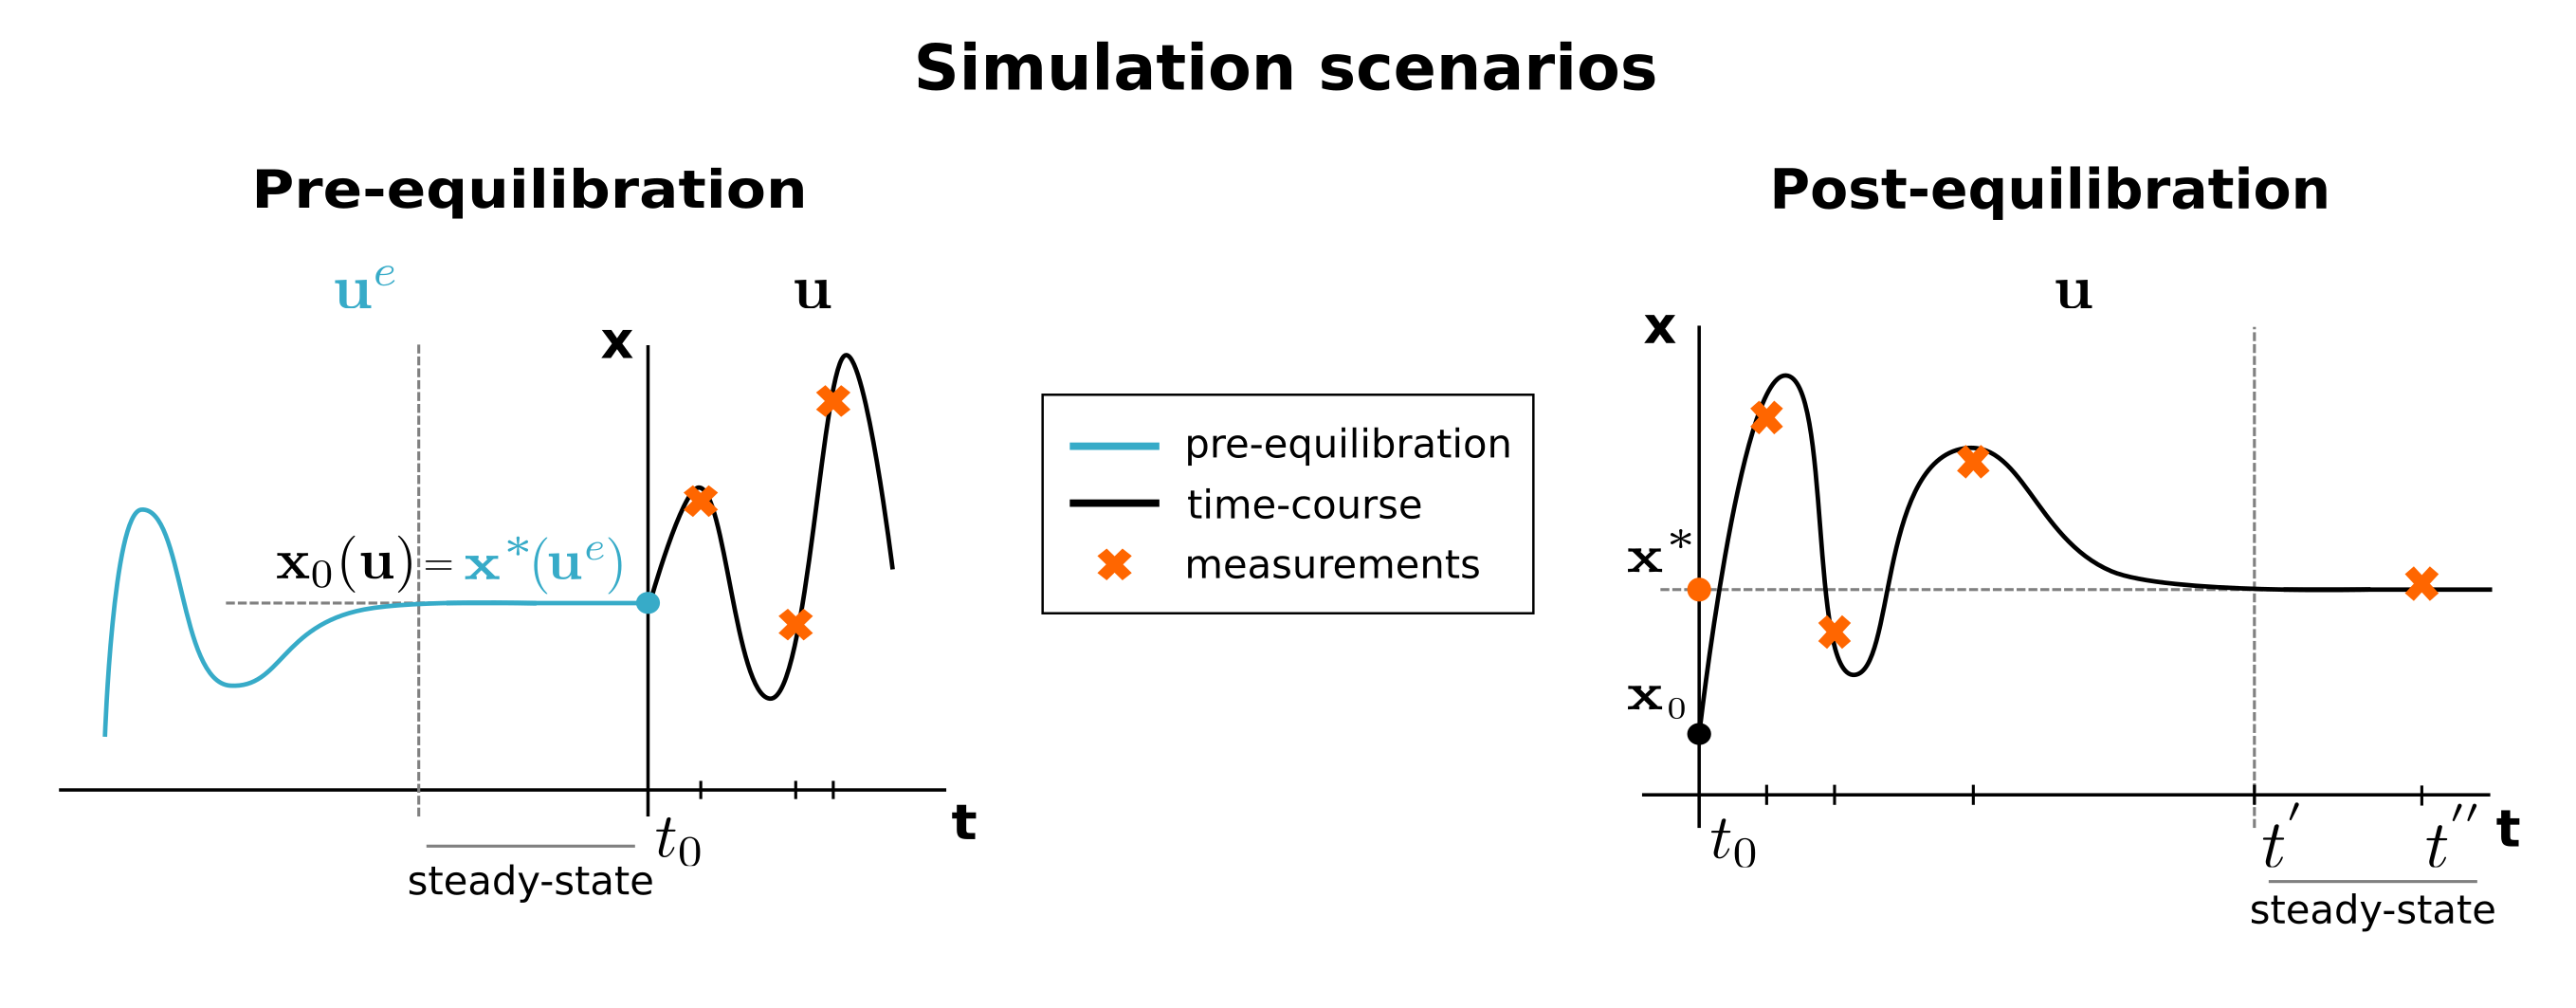



> **_NOTE:_** Not every dynamical system needs to run into a steady state. Instead, it may exhibit
>
>  * continuous growth, e.g., $$\dot{x} = x, \quad x_0 = 1$$
>  * a finite-time blow up, e.g., $$\dot{x} = x^2, \quad x_0 = 1$$
>  * oscillations, e.g., $$\ddot{x} = -x, \quad x_0 = 1$$
>  * chaotic behaviour, e.g., the Lorentz attractor
>

In this notebook we will discuss how one can perform pre- and post-equilibration using AMICI and compute sensitivites corresponding to the system’s steady state.

## The example model

We will use the example model `model_constant_species.xml`, which describes an enzymatic reaction 

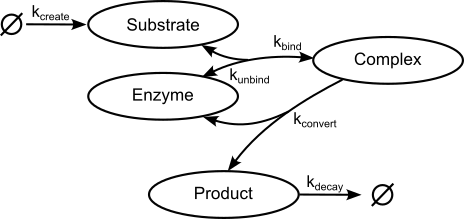

The corresponding system of ODEs is

$$
    \begin{array}{llll}
        \dot{s} = (\text{synthesis_substrate} + k_{\text{create}}) - k_{\text{bind}}\cdot s \cdot e + k_{\text{unbind}}\cdot c,\\
        \dot{e} = - k_{\text{bind}}\cdot s \cdot e + k_{\text{unbind}}\cdot c + k_{\text{convert}}\cdot c,\\
        \dot{c} = k_{\text{bind}}\cdot s \cdot e - k_{\text{unbind}}\cdot c - k_{\text{convert}}\cdot c,\\
        \dot{p} = k_{\text{convert}}\cdot c - k_{\text{decay}}\cdot p,
    \end{array} 
$$
where `s`, `e`, `c` and `p` are concentrations of substrate, enzyme, complex and product, respectively. 

This model has conserved quantities. Namely, the total amount of enzyme (complex + enzyme) remains constant over time. It can be seen from the ODEs: adding up the second and the third equations gives $ \dot{e} + \dot{c} = 0$. Conserved quantities in the model lead to a singular Jacobian, which makes some computational methods not applicable. For the system above the Jacobian is equal to
$$
\begin{bmatrix} 
- k_{\text{bind}}\cdot e & - k_{\text{bind}}\cdot s & k_{\text{unbind}} & 0\\ 
- k_{\text{bind}}\cdot e & - k_{\text{bind}}\cdot s & (k_{\text{unbind}} + k_{\text{convert}}) & 0\\
k_{\text{bind}}\cdot e &  k_{\text{bind}}\cdot s & -(k_{\text{unbind}} + k_{\text{convert}}) & 0\\
0 & 0 & k_{\text{convert}} & - k_{\text{decay}}
 \end{bmatrix}.
$$
It's easy to see that the first two columns (or the second and the third row) are linearly dependent and the determinant is equal to zero.

If one is able to identify a conserved quantity, the model dimension can be reduced by excluding one of the states. For example, for the model above one can remove the second ODE and redefine `e` as `enzyme_total - c`, where `enzyme_total` is a constant specifying the total concentration of enzyme. In general, conserved quantities or conserved moieties are functions of the sates of the dynamical system that remain constant over time. They can be automatically removed in the SBML import of AMICI, if an environment variable ``AMICI_EXPERIMENTAL_SBML_NONCONST_CLS`` is set. Further, we will consider two versions of the model, with and without the conserved quantity, to demonstrate the failure of the Newton's method for steady-state computation and two different approaches for sensitivities computation that are not applicable if Jacobian is singular.

In [7]:
import libsbml
import importlib
import amici
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# SBML model we want to import
sbml_file = 'model_constant_species.xml'

# Name of the models that will also be the name of the python module
model_name = 'model_constant_species'
model_reduced_name = model_name + '_reduced'

# Directories to which the generated model code is written
model_output_dir = model_name
model_reduced_output_dir = model_reduced_name

# Read the model and give some output
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()
dir(sbml_doc)

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s%s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s%s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print(f'{reaction.getId():>10}: {reactants:>18} {reversible:>1}-> {products:>16}  [{libsbml.formulaToL3String(reaction.getKineticLaw().getMath())}]')

Species:  ['substrate', 'enzyme', 'complex', 'product']

Reactions:
  creation:                     ->        substrate  [compartment * (synthesis_substrate + k_create)]
   binding: substrate + enzyme <->          complex  [compartment * (k_bind * substrate * enzyme - k_unbind * complex)]
conversion:            complex  -> enzyme + product  [compartment * k_convert * complex]
     decay:            product  ->                   [compartment * k_decay * product]


In [8]:
import os

# Create an SbmlImporter instance for our SBML model
sbml_importer = amici.SbmlImporter(sbml_file)

# specify observables and constant parameters
constantParameters = ['synthesis_substrate', 'init_enzyme']
observables = {
    'observable_product': {'name': '', 'formula': 'product'},
    'observable_substrate': {'name': '', 'formula': 'substrate'},
}
sigmas = {'observable_product': 1.0, 'observable_substrate': 1.0}

# import the model
sbml_importer.sbml2amici(model_name,
                         model_output_dir,
                         observables=observables,
                         constant_parameters=constantParameters,
                         sigmas=sigmas,
                         compute_conservation_laws=False)

# turn on removal of conservation laws and import the reduced model
os.environ["AMICI_EXPERIMENTAL_SBML_NONCONST_CLS"] = "1"
sbml_importer.sbml2amici(model_reduced_name,
                         model_reduced_output_dir,
                         observables=observables,
                         constant_parameters=constantParameters,
                         sigmas=sigmas)

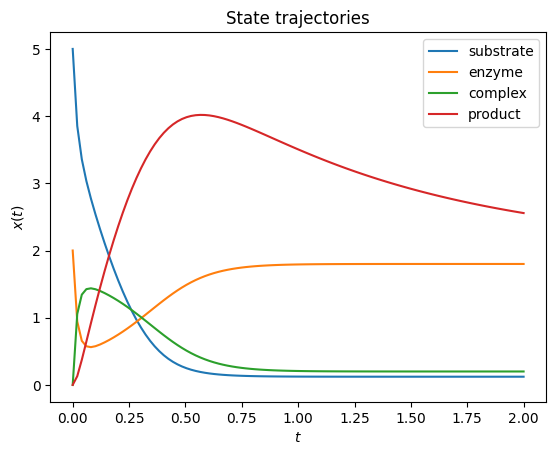

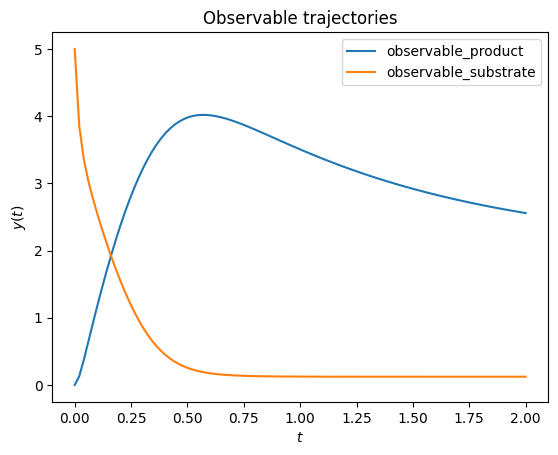

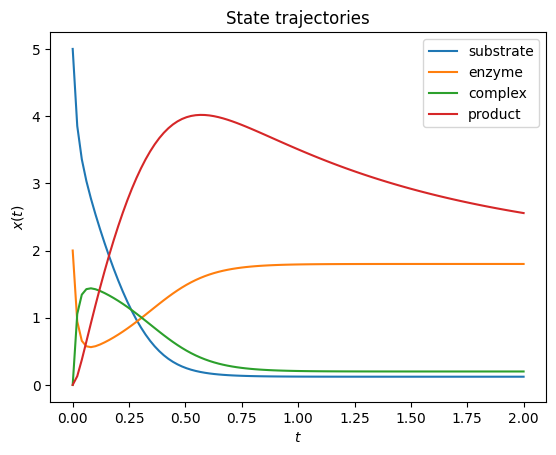

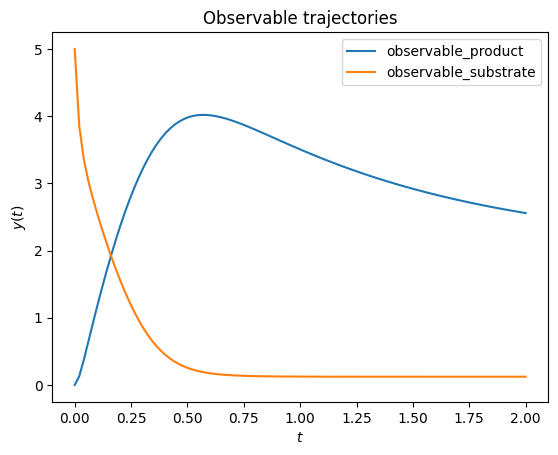

In [9]:
# import the models and run some test simulations
model_reduced_module = amici.import_model_module(model_reduced_name, os.path.abspath(model_reduced_output_dir))
model_reduced = model_reduced_module.getModel()

model_module = amici.import_model_module(model_name, os.path.abspath(model_output_dir))
model = model_module.getModel()

# simulate model with conservation laws
model.setTimepoints(np.linspace(0, 2, 100))
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

# simulate model without conservation laws
model_reduced.setTimepoints(np.linspace(0, 2, 100))
solver_reduced = model_reduced.getSolver()
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced)

# plot trajectories
import amici.plotting
amici.plotting.plotStateTrajectories(rdata, model=model)
amici.plotting.plotObservableTrajectories(rdata, model=model)

amici.plotting.plotStateTrajectories(rdata_reduced, model=model_reduced)
amici.plotting.plotObservableTrajectories(rdata_reduced, model=model_reduced)

In [12]:
# the enzyme state was removed from the ODEs of the reduced model
print(model.getStateIdsSolver())
print(model_reduced.getStateIdsSolver())

('substrate', 'enzyme', 'complex', 'product')
('substrate', 'complex', 'product')


## Steady-state computation

Two approaches are available in AMICI for steady-state computation: 
1. Newton's method
2. Numerical integration until time derivatives $\dot{x}$ become sufficiently small. Namely, numerical integration is performed until the condition 
$$
    \sqrt{\frac 1 n_x \sum_{i=1}^{n_x} (\dot{x}_i w_i)^2} < 1, \quad \text{where} \; w_i = \frac{1}{\text{rtol}*x_i + \text{atol}}
    \label{eq:wrms}
$$
is fulfilled, where “rtol” and “atol” denote relative and absolute tolerances, respectively. 

In general, the Newton's method is significantly faster than numerical integration. However, it will converge only if started close enough to the steady state. More about the convergence of the Newton's method and its implementation in AMICI can be found in [Lines et al. (2019)](https://doi.org/10.1016/j.ifacol.2019.12.232). Moreover, the Newton's method is only applicable if system's Jacobian is non-singular. 

>By default, the Newton's method is attempted first. If it fails, numerical integration is performed instead. If it fails as well, Newton's method is performed again starting from the final point of the numerical integration.

Many parameters, such as maximum allowed number of steps for the Newton's method or numerical integration or values of tolerances, influence steady-state computation. 

In the next section we will try applying Newton's method to the models with and without conserved quantities, demonstrate how to set relevant parameters and interpret the data returned by simulation.

### Inferring the steady state of the system (postequilibration)

In order to run post-equilibration one needs to add t=$\infty$ to the list of timepoints. It can be the only timepoint or one can also set a number of finite timepoints.
First, we want to demonstrate that the Newton's method will fail with the unreduced model due to a singular right hand side Jacobian.

In [22]:
# Call postequilibration by setting an infinity timepoint
model.setTimepoints([np.inf])

# Set the solver
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setMaxSteps(1000) # maximum number of solver steps for numerical integration
rdata = amici.runAmiciSimulation(model, solver)

# print out a subset of data returned by model simulation
for key in ['ts', 'x', 'xdot', 'posteq_wrms', 
            'posteq_t', 'posteq_numsteps', 'posteq_numstepsB', 
            'posteq_status', 'posteq_cpu_time', 'posteq_cpu_timeB']:
    print(f'{key:>16}: {rdata[key]}')
    


              ts: [inf]
               x: [[0.12222222 1.8        0.2        2.00000314]]
            xdot: [ 0.00000000e+00 -2.22044605e-16  2.22044605e-16 -3.13675608e-06]
     posteq_wrms: 0.7841877852857544
        posteq_t: 14.095659672046486
 posteq_numsteps: [[  0 463   0]]
posteq_numstepsB: 0.0
   posteq_status: [[-3  1  0]]
 posteq_cpu_time: 2.636
posteq_cpu_timeB: 0.0


The 'x' value contains state values corresponding to the time points that were set for the model simulation. In this case, it is the state values at $t=\infty$, i.e. the steady state. One can also see that `xdot` values are equal to zero or very small, which means that the steady-state condition ($\dot{x} = 0$) is fulfilled. 

The fields `posteq_status` and `posteq_numsteps` in rdata tell us how postequilibration worked. In both arrays each entry is, respectively, the status or the number of steps taken for

  1. the Newton's method run;
  2. the numerical integration run; 
  3. the second Newton's method run, starting from the simulation results.

The status is encoded as an Integer flag with the following meanings:

  * ` 1`: Successful run
  * ` 0`: Did not run
  * `-1`: Error: No further specification is given, the error message should give more information.
  * `-2`: Error: The method did not converge to a steady state within the maximum number of steps (Newton's method or simulation).
  * `-3`: Error: The Jacobian of the right hand side is singular (only Newton's method)
  * `-4`: Error: The damping factor in Newton's method was reduced until it met the lower bound without success (Newton's method only)
  * `-5`: Error: The model was simulated past the timepoint `t=1e100` without finding a steady state. Therefore, it is likely that the model has no steady state for the given parameter vector.
  
  

In our case, only the second entry of `posteq_status` contains a positive integer: The first run of Newton's method failed due to a Jacobian, which could not be factorized, but the second run (simulation) contains the entry 1 (success). The third entry is 0, thus Newton's method was not launched for the second time.
More information can be found in`posteq_numsteps`: Also here, only the second entry contains a positive integer, which is smaller than the allowed maximum number of steps (1000). Hence, steady state was reached via simulation, which corresponds to the simulated time written to `posteq_time`.

We can simulate the system until $t=14$ and see that, indeed, the system converges to the steady-state value, which is equal to `rdata['x'][0]`. 

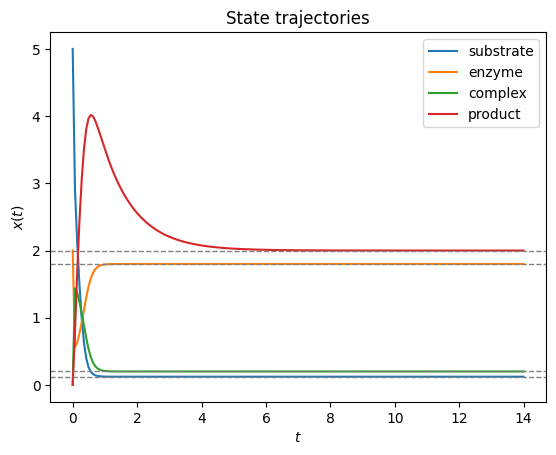

In [23]:
steady_state = rdata['x'][0]

timepoints = np.linspace(0, 14, 200)
model.setTimepoints(timepoints)
rdata = amici.runAmiciSimulation(model, solver)
amici.plotting.plotStateTrajectories(rdata, model=model)

for stst_value in steady_state:
    plt.axhline(y = stst_value, color = 'gray', linestyle = '--', linewidth=1)

We want to demonstrate a complete failure during the steady-state computation by reducing the number of integration steps to a lower value:

In [27]:
# reduce maxsteps for integration
model.setTimepoints([np.inf])
solver.setMaxSteps(100)
rdata = amici.runAmiciSimulation(model, solver)
print('Simulation status:', rdata['status'])
print('Status of postequilibration:', rdata['posteq_status'])
print('Number of steps employed in postequilibration:', rdata['posteq_numsteps'])

2023-03-14 17:40:34.317 - amici.swig_wrappers - DEBUG - [EQUILIBRATION_FAILURE] AMICI equilibration exceeded maximum number of integration steps at t=0.0210705.
2023-03-14 17:40:34.318 - amici.swig_wrappers - ERROR - [OTHER] AMICI simulation failed: Steady state computation failed. First run of Newton solver failed: RHS could not be factorized. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: RHS could not be factorized.
2023-03-14 17:40:34.319 - amici.swig_wrappers - DEBUG - [BACKTRACE] The previous error occurred at:
2       0x7fc2d3bbba27 /home/polina/Documents/Development/AMICI/venv/lib/python3.8/site-packages/amici/_amici.cpython-38-x86_64-linux-gnu.so(+0xb4a27) [0x7fc2d3bbba27]
3       0x7fc2d3ccdde2 amici::SteadystateProblem::findSteadyState(amici::Solver const&, amici::Model&, int) + 418
4       0x7fc2d3ccde2f amici::SteadystateProblem::workSteadyStateProblem(amici::Solver const&, amici::Model&, int) + 63
5       0x7fc2d3c799ee

Simulation status: -99
Status of postequilibration: [[-3 -2 -3]]
Number of steps employed in postequilibration: [[  0 100   0]]


However, the same logic works, if we use the reduced model.
For sufficiently many Newton steps, postequilibration is achieved by Newton's method in the first run. In this specific example, the steady state is found within one step.

In [29]:
model_reduced.setTimepoints([np.inf])

# set the solver
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setMaxSteps(100)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced)

print('Simulation status:', rdata_reduced['status'])
print('Steady-state value:', rdata_reduced['x'][0])
print('Status of postequilibration:', rdata_reduced['posteq_status'])
print('Number of steps employed in postequilibration:', rdata_reduced['posteq_numsteps'])

Simulation status: 0
Steady-state value: [0.12222222 1.8        0.2        2.        ]
Status of postequilibration: [[1 0 0]]
Number of steps employed in postequilibration: [[2 0 0]]


## Sensitivities computation at steady state

In addition to model simulation, AMICI supports forward sensitivity analysis and adjoint sensitivity analysis for likelihood-based output functions, which is crucial for parameter estimation. Both sensitivity analysis approaches can be adapted to exploit steady-state constraints.

### Postequilibration with sensitivities

<!-- Equilibration is possible with forward and adjoint sensitivity analysis. As for the main simulation part, adjoint sensitivity analysis yields less information than forward sensitivity analysis, since no state sensitivities are computed. However, it has a better scaling behavior towards large model sizes. -->

#### Postequilibration with forward sensitivities

If forward sensitivity analysis is used, then state sensitivities at the timepoint `np.inf` will be computed. This can be done in (currently) two different ways:

1. One can integrate the state variables with state sensitivities until the norm of the right-hand side becomes small. This approach is numerically more stable, but the computation time for large models may be substantial.
<!-- This approach will be chosen by AMICI, if the steady state was found by simulation and the option `model.SteadyStateSensitivityMode` is set to `SteadyStateSensitivityMode.simulationFSA`.  -->

2. The more efficient approach is to take into account the steady-state condition ($\dot{x} = 0$), which allows to symplify the ODE system for state sentitivities into the linear system of equations: $$0 = \left.\dot{\mathbf{s}}^x\right\vert_{\mathbf{x} = \mathbf{x}^*({\theta})} = \mathbf{J}(\mathbf{x}^*({\theta}), {\theta}) \left.\mathbf{s}^x\right\vert_{\mathbf{x} = \mathbf{x}^*({\theta})} + \left.\frac{\partial \mathbf{f}}{\partial \theta}\right\vert_{\mathbf{x} = \mathbf{x}^*({\theta})}\qquad \Rightarrow \qquad \mathbf{J}(\mathbf{x}^*({\theta}), {\theta}) \left.\mathbf{s}^x\right\vert_{\mathbf{x} = \mathbf{x}^*({\theta})} = - \left.\frac{\partial \mathbf{f}}{\partial \theta}\right\vert_{\mathbf{x} = \mathbf{x}^*({\theta})},$$ where $\mathbf{s}^x$ are the state sensitivies, $\mathbf{f}$ - is the right-hand side of the model ODEs, $\theta$ - model parameters and $\mathbf{J}(\mathbf{x}^*({\theta}), {\theta}) = \left.\nabla_x \mathbf{f}\right\vert_{\mathbf{x} = \mathbf{x}^*({\theta})}$ is the systems's Jacobian at steady state. However, this method is only applicable if the Jacobian is not (close to) singular.

   This approach will always be chosen by AMICI, if the option `model.SteadyStateSensitivityMode` is set to `SteadyStateSensitivityMode.newtonOnly`. Furthermore, it will also be chosen, if the steady state was found by Newton's method, as in this case, the Jacobian is at least not singular (but may still be poorly conditioned). 
<!--    A check for the condition number of the Jacobian is currently missing, but will soon be implemented. -->

Side remark:
A possible third way may consist in a (relaxed) Richardson iteration type approach, which interprets the entries of the right hand side $f$ as residuals and minimizes the squared residuals $\Vert f \Vert^2$ by a Levenberg-Marquart-type algorithm. This approach would also work for poorly conditioned (and even for singular Jacobians if additional constraints are implemented as Lagrange multipliers) while being faster than a long forward simulation.

We want to demonstrate both possibilities for steady-state sensitivities computation, as well as the failure of their computation if the Jacobian is singular and the `newtonOnly` setting was used.

In [35]:
# todo: better summary of SteadyStateSensitivityModes
# todo: integrationOnly

In [37]:
# Call simulation with singular Jacobian and `integrateIfNewtonFails` mode
model.setTimepoints([np.inf])
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.integrateIfNewtonFails)
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
solver.setMaxSteps(10000)
rdata = amici.runAmiciSimulation(model, solver)

np.set_printoptions(threshold=20)
print('Simulation status:', rdata['status'])
print('Status of postequilibration:', rdata['posteq_status'])
print('Number of steps employed in postequilibration:', rdata['posteq_numsteps'])
print('Computed state sensitivities:')
print(rdata['sx'][0,:,:])


Simulation status: 0
Status of postequilibration: [[-3  1  0]]
Number of steps employed in postequilibration: [[   0 1121    0]]
Computed state sensitivities:
[[-1.22222222e-02  4.63807322e-18  6.34467588e-18 -6.84150375e-15]
 [ 1.11111111e-02 -1.49385095e-17  1.63814221e-17  6.68833205e-15]
 [-2.46913580e-03  2.00000000e-02 -2.00000000e-02 -1.78450753e-14]
 [ 6.79012346e-02 -1.00000000e-01  1.00000000e-01  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.00000000e+00]]


As can be seen from the `posteq_status`, the Newton's method didn't work, but the steady state and corresponding sensitivities were computed by numerical integration.
The shape of `rdata['sx']` is (number of timepoints) x (number of parameters) x (number of states).

In [38]:
# Call simulation with singular Jacobian and newtonOnly mode (will fail)
model.setTimepoints([np.inf])
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.newtonOnly)
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
solver.setMaxSteps(10000)
rdata = amici.runAmiciSimulation(model, solver)

print('Simulation status:', rdata['status'])
print('Steady state:', rdata['x'])
print('Status of postequilibration:', rdata['posteq_status'])
print('Number of steps employed in postequilibration:', rdata['posteq_numsteps'])
print('Computed state sensitivities:')
print(rdata['sx'][0,:,:])

2023-03-14 19:23:00.184 - amici.swig_wrappers - ERROR - [OTHER] AMICI simulation failed: Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian
2023-03-14 19:23:00.185 - amici.swig_wrappers - DEBUG - [BACKTRACE] The previous error occurred at:
2       0x7fc2d3bbc0ff /home/polina/Documents/Development/AMICI/venv/lib/python3.8/site-packages/amici/_amici.cpython-38-x86_64-linux-gnu.so(+0xb50ff) [0x7fc2d3bbc0ff]
3       0x7fc2d3c799ee amici::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 2686
4       0x7fc2d3c18d93 /home/polina/Documents/Development/AMICI/venv/lib/python3.8/site-packages/amici/_amici.cpython-38-x86_64-linux-gnu.so(+0x111d93) [0x7fc2d3c18d93]
5             0x5f42ea PyCFunction_Call + 250



Simulation status: -99
Steady state: [[0.12222222 1.8        0.2        2.00000314]]
Status of postequilibration: [[-3  1  0]]
Number of steps employed in postequilibration: [[  0 463   0]]
Computed state sensitivities:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


For the model with singular Jacobian steady-state computation worked by numerical integration. However, for sensitivities comutation `amici.SteadyStateSensitivityMode.newtonOnly` approach was chosen which fails with singular Jacobian and the sensitivites could not be computed. 
We can try the same with the reduced model:

In [44]:
# Try `newtonOnly` option with reduced model
model_reduced.setTimepoints([np.inf])
model_reduced.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.newtonOnly)
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.forward)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
solver_reduced.setMaxSteps(1000)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced)

print('Simulation status:', rdata_reduced['status'])
print('Steady state:', rdata_reduced['x'])
print('Status of postequilibration:', rdata_reduced['posteq_status'])
print('Number of steps employed in postequilibration:', rdata_reduced['posteq_numsteps'])
print('Computed state sensitivities:')
print(rdata_reduced['sx'][0,:,:])

Simulation status: 0
Steady state: [[0.12222222 1.8        0.2        2.        ]]
Status of postequilibration: [[1 0 0]]
Number of steps employed in postequilibration: [[2 0 0]]
Computed state sensitivities:
[[-0.01222222  0.          0.          0.        ]
 [ 0.01111111  0.          0.          0.        ]
 [-0.00246914  0.02       -0.02        0.        ]
 [ 0.06790123 -0.1         0.1         1.        ]
 [ 0.          0.          0.         -2.        ]]


In this case, both steady state and the corresponding sensitivities could be computed by solving the linear systems $\mathbf{s}^x = - \frac{\partial \mathbf{f}}{\partial \theta}$ for state sensitivities ($\mathbf{s}^x$).

#### Postequilibration with adjoint sensitivities

Postequilibration also works with adjoint sensitivity analysis and, similar to forward sensitivites, two approaches are available for sensitivities computation at steady state: 

1. Standard adjoint sensitivity analysis can be performed to compute objective function gradient. This approach requires backward numerical integration of the adjoint state ODE form the timepoint of the steady-state measurements $t=t''$ (practically, $t''$ = `posteq_t`, at this time point steady-state condition was satisfied) until the last finite timepoint ($t_{n_t}$). Ultimately, one needs to compute
$$
\int_{t_{n_t}}^{t''}\mathbf{p}(t, {\theta})^T\left.\frac{\partial \mathbf{f}}{\partial \theta_k}\right|_{\textbf{x}(t, {\theta}),{\theta}}dt,
$$
where $\mathbf{p}$ is the adjoint state, $\theta$ - model parameters.
<!-- $$
\quad \dot{\mathbf{p}}(t,{\theta}, \mathbf{u}) = -\mathbf{J}(\mathbf{x}(t, {\theta}, \mathbf{u}), {\theta}, \mathbf{u})^T \mathbf{p}(t,{\theta}, \mathbf{u}), 
    \label{eq:adjoint_ode}
$$
with boundary values
$$
\begin{split}
\mathbf{p}(t_j,{\theta}, \mathbf{u}) = \lim_{t\rightarrow t_j^+} \mathbf{p}(t,{\theta}, \mathbf{u}) + \sum^{n_y}_{j=1} \left.\frac{\partial h_i}{\partial \mathbf{x}}\right\vert^T_{(\mathbf{x}(t_j,{\theta}, \mathbf{u}), {\theta}, \mathbf{u})} \frac{(\bar{y}_{ij} - y_i(t_j, {\theta}, \mathbf{u}))}{\sigma^2_{ij}}, \quad \text{and} \\ 
\lim_{t \rightarrow t_{n_t}^+} \mathbf{p}(t,{\theta}, \mathbf{u})=0,
\end{split}
$$
where $\mathbf{p}$ is the adjoint state, $\theta$ - model parameters, $J$ - Jacobian. -->

2. Alternatively, one can exploit steady-state condition and speed up the computation. It can be shown that the integral 
$$
\int_{t_{n_t}}^{t''}\mathbf{p}(t, {\theta})^T\left.\frac{\partial \mathbf{f}}{\partial \theta_k}\right|_{\textbf{x}(t, {\theta}),{\theta}}dt
$$
    can be reduced to a matrix-vector product
$$
\int^{t''}_{t'} 
\mathbf{p}(t, {\theta}, \mathbf{u})^T dt \cdot \left.
\frac{\partial \mathbf{f}}
{\partial \theta_k}
\right\vert_{\mathbf{x} = \mathbf{x}^*({\theta})}dt 
= 
\mathbf{p}_{\text{integral}} 
\cdot \left.
\frac{\partial \mathbf{f}}
{\partial \theta_k}
\right\vert_{\mathbf{x} = \mathbf{x}^*({\theta})},
$$
    where $t'$ is a time point such that $t_{n_t} \ll t' \ll t''$ and for $t \geq t'$ the system  is at steady state. To obtain the integral one can solve the linear system of equations
$$
    \mathbf{J}(\mathbf{x}^*({\theta}), {\theta})^T \mathbf{p}_{\text{integral}} = -\mathbf{p}(t'', {\theta}).
$$
   The detailed explanation of this approach and the derivation of the last equation can be found in [Lakrisenko et al. (2023)](https://doi.org/10.1371/journal.pcbi.1010783).
   
   However, this solution is given in terms of a linear system of equations defined by the transposed Jacobian of the right-hand side. Hence, if the (transposed) Jacobian is singular, it is not applicable. In this case, standard integration must be carried out.

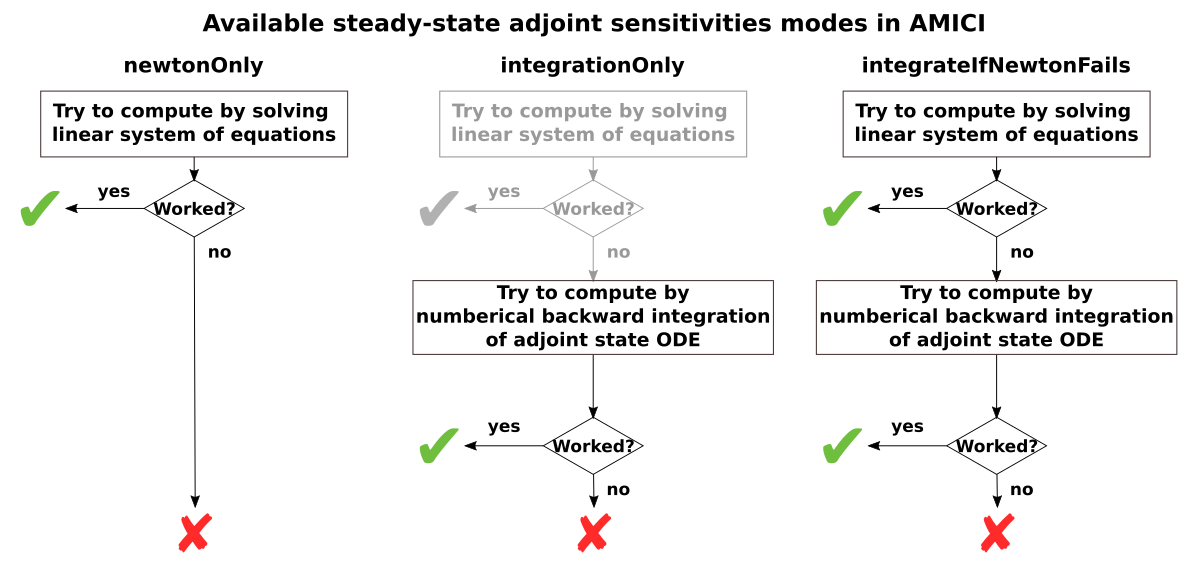

> **_NOTE:_** adjoint sensitivity analysis yields less information than forward sensitivity analysis, since state sensitivities are not computed. However, it has a better scaling behavior towards large model size.

In [40]:
# todo: standard ASA first

In [41]:
# Call postequilibration and sensitivities computation using adjoint sensitivity analysis 
# by setting an infinity timepoint
# and createíng an edata object, which is needed for adjoint computation
edata = amici.ExpData(2, 0, 0, np.array([float('inf')]))
edata.setObservedData([1.8] * 2)
edata.fixedParameters = np.array([3., 5.])

model_reduced.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.newtonOnly)
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
solver_reduced.setMaxSteps(1000)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

print('Simulation status:', rdata_reduced['status'])
print('Status of postequilibration:', rdata_reduced['posteq_status'])
print('Number of steps employed in postequilibration:', rdata_reduced['posteq_numsteps'])
print('Number of backward steps employed in postequilibration:', rdata_reduced['posteq_numstepsB'])
print('Computed gradient:', rdata_reduced['sllh'])

Simulation status: 0
Status of postequilibration: [[1 0 0]]
Number of steps employed in postequilibration: [[2 0 0]]
Number of backward steps employed in postequilibration: 0.0
Computed gradient: [-2.05061728e-02  1.86419753e-02 -4.14266118e-03 -3.15443073e+00
  1.60000000e+01]


If we carry out the same computation with a system that has a singular Jacobian, then `posteq_numstepsB` will not be `0` any more (which indicates that the linear system solve was used to compute backward postequilibration).
Now, integration is carried out and hence `posteq_numstepsB > 0`:

In [42]:
# Call adjoint postequilibration with model with singular Jacobian
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.newtonOnly)
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
rdata = amici.runAmiciSimulation(model, solver, edata)

print('Simulation status:', rdata['status'])
print('Status of postequilibration:', rdata['posteq_status'])
print('Number of steps employed in postequilibration:', rdata['posteq_numsteps'])
print('Number of backward steps employed in postequilibration:', rdata['posteq_numstepsB'])
print('Computed gradient:', rdata['sllh'])

2023-03-14 21:37:59.926 - amici.swig_wrappers - ERROR - [OTHER] AMICI simulation failed: Steady state backward computation failed: Linear system could not be solved (possibly due to singular Jacobian), and numerical integration did not equilibrate within maxsteps
2023-03-14 21:37:59.927 - amici.swig_wrappers - DEBUG - [BACKTRACE] The previous error occurred at:
2       0x7fc2d3bbbd2e /home/polina/Documents/Development/AMICI/venv/lib/python3.8/site-packages/amici/_amici.cpython-38-x86_64-linux-gnu.so(+0xb4d2e) [0x7fc2d3bbbd2e]
3       0x7fc2d3ccd3e6 amici::SteadystateProblem::workSteadyStateBackwardProblem(amici::Solver const&, amici::Model&, amici::BackwardProblem const*) + 54
4       0x7fc2d3c79936 amici::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 2502
5       0x7fc2d3c18d93 /home/polina/Documents/Development/AMI


Simulation status: -99
Status of postequilibration: [[-3  1  0]]
Number of steps employed in postequilibration: [[  0 408   0]]
Number of backward steps employed in postequilibration: 0.0
Computed gradient: [nan nan nan nan nan]


## Preequilibrating the model

Sometimes, we want to launch a solver run from a steady state which was inferred numerically, i.e., the system was preequilibrated. In order to do this with AMICI, we need to pass an ExpData object, which contains fixed parameter for the actual simulation and for preequilibration of the model.

In [18]:
# create edata, with 3 timepoints and 2 observables:
edata = amici.ExpData(2, 0, 0,
                      np.array([0., 0.1, 1.]))
edata.setObservedData([1.8] * 6)
edata.fixedParameters = np.array([3., 5.])
edata.fixedParametersPreequilibration = np.array([0., 2.])
edata.reinitializeFixedParameterInitialStates = True

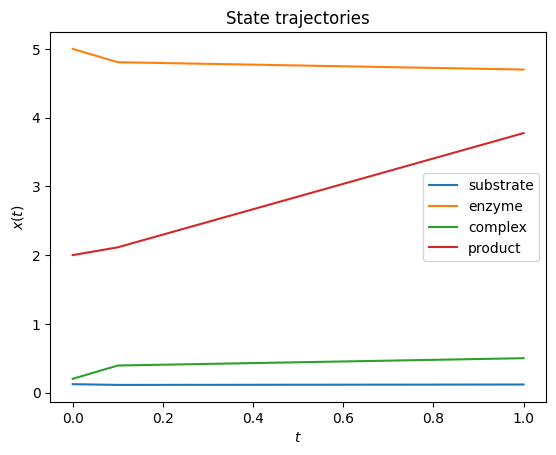

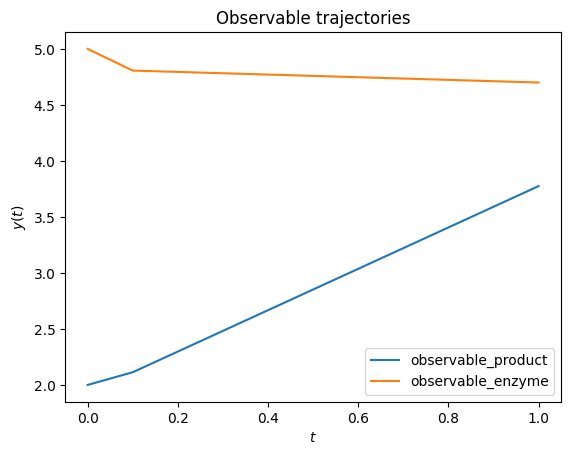

In [19]:
# create the solver object and run the simulation
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

amici.plotting.plotStateTrajectories(rdata_reduced, model = model_reduced)
amici.plotting.plotObservableTrajectories(rdata_reduced, model = model_reduced)

We can also combine pre- and postequilibration.

In [20]:
# Change the last timepoint to an infinity timepoint.
edata.setTimepoints(np.array([0., 0.1, float('inf')]))

# run the simulation
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

## Preequilibration with sensitivities

Beyond the need for an ExpData object, the steady state solver logic in preequilibration is the same as in postequilibration, also if sensitivities are requested. The computation will fail for singular Jacobians, if `SteadyStateSensitivityMode` is set to `newtonOnly`, or if not enough steps can be taken.
However, if forward simulation with steady state sensitivities is allowed, or if the Jacobian is not singular, it will work.

### Prequilibration with forward sensitivities

In [21]:
# No postquilibration this time.
edata.setTimepoints(np.array([0., 0.1, 1.]))

# create the solver object and run the simulation, singular Jacobian, enforce Newton solver for sensitivities
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.newtonOnly)
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
rdata = amici.runAmiciSimulation(model, solver, edata)

for key, value in rdata.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)

2023-03-14 13:49:00.107 - amici.swig_wrappers - ERROR - [OTHER] AMICI simulation failed: Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian
2023-03-14 13:49:00.107 - amici.swig_wrappers - DEBUG - [BACKTRACE] The previous error occurred at:
2       0x7fc036cba0ff /home/polina/Documents/Development/AMICI/venv/lib/python3.8/site-packages/amici/_amici.cpython-38-x86_64-linux-gnu.so(+0xb50ff) [0x7fc036cba0ff]
3       0x7fc036d770ad amici::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 317
4       0x7fc036d16d93 /home/polina/Documents/Development/AMICI/venv/lib/python3.8/site-packages/amici/_amici.cpython-38-x86_64-linux-gnu.so(+0x111d93) [0x7fc036d16d93]
5             0x5f42ea PyCFunction_Call + 250
6


          preeq_wrms:  0.7841877852857544
             preeq_t:  14.095659672046486
      preeq_numsteps:  [[  0 463   0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[-3  1  0]]
      preeq_cpu_time:  2.825
     preeq_cpu_timeB:  0.0


In [22]:
# Singluar Jacobian, use simulation
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.integrateIfNewtonFails)
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
rdata = amici.runAmiciSimulation(model, solver, edata)

for key, value in rdata.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)

          preeq_wrms:  4.554689935708259e-06
             preeq_t:  29.460678852145364
      preeq_numsteps:  [[   0 1121    0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[-3  1  0]]
      preeq_cpu_time:  14.365
     preeq_cpu_timeB:  0.0


In [23]:
# Non-singular Jacobian, use Newton solver
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.forward)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

for key, value in rdata_reduced.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)

          preeq_wrms:  7.777020191010815e-09
             preeq_t:  nan
      preeq_numsteps:  [[2 0 0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[1 0 0]]
      preeq_cpu_time:  0.033
     preeq_cpu_timeB:  0.0


### Prequilibration with adjoint sensitivities


When using preequilibration, adjoint sensitivity analysis can be used for simulation. This is a particularly interesting case: Standard adjoint sensitivity analysis requires the initial state sensitivities `sx0` to work, at least if data is given for finite (i.e., not exclusively postequilibration) timepoints:
For each parameter, a contribution to the gradient is given by the scalar product of the corresponding state sensitivity vector at timepoint $t=0$, (column in `sx0`), with the adjoint state ($p(t=0)$). Hence, the matrix `sx0` is needed. This scalar product "closes the loop" from forward to adjoint simulation.

By default, if adjoint sensitivity analysis is called with preequilibration, the initial state sensitivities are computed in just the same way as if this way done for forward sensitivity analysis. The only difference in the internal logic is that, if the steady state gets inferred via simulation, a separate solver object is used in order to ensure that the steady state simulation does not interfere with the snapshotting of the forward trajectory from the actual time course.

However, also an adjoint version of preequilibration is possible: In this case, the "loop" from forward to adjoint simulation needs no closure: The simulation time is extended by preequilibration: forward from $t = -\infty$ to $t=0$, and after adjoint simulation also backward from $t=0$ to $t = -\infty$. Similar to adjoint postequilibration, the steady state of the adjoint state (at $t=-\infty$) is $p=0$, hence the scalar product (at $t=-\infty$) for the initial state sensitivities of preequilibration with the adjoint state vanishes. Instead, this gradient contribution is covered by additional quadratures $\int_{-\infty}^0 p(s) ds \cdot \frac{\partial f}{\partial \theta}$. In order to compute these quadratures correctly, the adjoint state from the main adjoint simulation must be passed on to the initial adjoint state of backward preequilibration.

However, as the adjoint state must be passed on from backward computation to preequilibration, it is currently not allowed to alter (reinitialize) states of the model at $t=0$, unless these states are constant, as otherwise this alteration would lead to a discontinuity in the adjoints state as well and hence to an incorrect gradient.

In [24]:
# Non-singular Jacobian, use Newton solver and adjoints with initial state sensitivities
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

for key, value in rdata_reduced.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)
print('Gradient:', rdata_reduced['sllh'])

          preeq_wrms:  7.777020191010815e-09
             preeq_t:  nan
      preeq_numsteps:  [[2 0 0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[1 0 0]]
      preeq_cpu_time:  0.048
     preeq_cpu_timeB:  0.0
Gradient: [-1.13623096e-03  2.27710447e-03 -1.43016594e-01 -2.47291188e+00
  6.33324891e+00]


In [25]:
# Non-singular Jacobian, use simulation solver and adjoints with initial state sensitivities
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(0)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

for key, value in rdata_reduced.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)
print('Gradient:', rdata_reduced['sllh'])

          preeq_wrms:  0.9972941864795635
             preeq_t:  13.996121981443599
      preeq_numsteps:  [[  0 465   0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[0 1 0]]
      preeq_cpu_time:  2.059
     preeq_cpu_timeB:  0.0
Gradient: [-1.13622855e-03  2.27709768e-03 -1.43016635e-01 -2.47291983e+00
  6.33327230e+00]


In [26]:
# Non-singular Jacobian, use Newton solver and adjoints with fully adjoint preequilibration
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver_reduced.setSensitivityMethodPreequilibration(amici.SensitivityMethod.adjoint)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

for key, value in rdata_reduced.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)
print('Gradient:', rdata_reduced['sllh'])

          preeq_wrms:  7.777020191010815e-09
             preeq_t:  nan
      preeq_numsteps:  [[2 0 0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[1 0 0]]
      preeq_cpu_time:  0.095
     preeq_cpu_timeB:  0.014
Gradient: [-1.13623047e-03  1.89438622e-03 -3.24941651e-01 -1.56520020e+00
  6.33324892e+00]


As for postquilibration, adjoint preequilibration has an analytic solution (via the linear system), which will be preferred. If used for models with singular Jacobian, numerical integration will be carried out, which is indicated by `preeq_numstepsB`.

In [27]:
# Non-singular Jacobian, use Newton solver and adjoints with fully adjoint preequilibration
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver.setSensitivityMethodPreequilibration(amici.SensitivityMethod.adjoint)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
rdata = amici.runAmiciSimulation(model, solver, edata)

for key, value in rdata.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)
print('Gradient:', rdata['sllh'])

          preeq_wrms:  0.9801751330298897
             preeq_t:  19.44882854480026
      preeq_numsteps:  [[  0 463   0]]
     preeq_numstepsB:  567.0
        preeq_status:  [[-3  1  0]]
      preeq_cpu_time:  3.307
     preeq_cpu_timeB:  3.848
Gradient: [-1.13622876e-03  2.27709812e-03 -3.25026736e-01 -1.56286857e+00
  6.33327015e+00]


## Controlling the error tolerances in pre- and postequilibration

When solving ODEs or DAEs, AMICI uses the default logic of CVODES and IDAS to control error tolerances. This means that error weights are computed based on the absolute error tolerances and the product of current state variables of the system and their respective relative error tolerances. If this error combination is then controlled.

The respective tolerances for equilibrating a system with AMICI can be controlled by the user via the getter/setter functions `[get|set][Absolute|Relative]ToleranceSteadyState[Sensi]`:

In [28]:
# Non-singular Jacobian, use simulaiton
model_reduced.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.integrateIfNewtonFails)
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(0)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.forward)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)

# run with lax tolerances
solver_reduced.setRelativeToleranceSteadyState(1e-2)
solver_reduced.setAbsoluteToleranceSteadyState(1e-3)
solver_reduced.setRelativeToleranceSteadyStateSensi(1e-2)
solver_reduced.setAbsoluteToleranceSteadyStateSensi(1e-3)
rdata_reduced_lax = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

# run with strict tolerances
solver_reduced.setRelativeToleranceSteadyState(1e-12)
solver_reduced.setAbsoluteToleranceSteadyState(1e-16)
solver_reduced.setRelativeToleranceSteadyStateSensi(1e-12)
solver_reduced.setAbsoluteToleranceSteadyStateSensi(1e-16)
rdata_reduced_strict = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

# compare ODE outputs
print('\nODE solver steps, which were necessary to reach steady state:')
print('lax tolerances: ', rdata_reduced_lax['preeq_numsteps'])
print('strict tolerances: ', rdata_reduced_strict['preeq_numsteps'])

print('\nsimulation time corresponding to steady state:')
print(rdata_reduced_lax['preeq_t'])
print(rdata_reduced_strict['preeq_t'])

print('\ncomputation time to reach steady state:')
print(rdata_reduced_lax['preeq_cpu_time'])
print(rdata_reduced_strict['preeq_cpu_time'])


ODE solver steps, which were necessary to reach steady state:
lax tolerances:  [[  0 774   0]]
strict tolerances:  [[   0 1104    0]]

simulation time corresponding to steady state:
6.189649066270984
34.702995828419795

computation time to reach steady state:
11.017
21.335
